In [8]:
import numpy as np
from scipy import interpolate, integrate

import matplotlib.pyplot as plt

import pathos.pools
import pathos.multiprocessing as mp

%matplotlib inline

import mc
import kinematics as kin

fig_size = [7, 3.15]

#from cycler import cycler
# Color cycle from https://gist.github.com/huyng/816622
#c = cycler('color', ['#348ABD', '#7A68A6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'])
#axes.color_cycle    : [348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33]
                      # E24A33 : orange
                      # 7A68A6 : purple
                      # 348ABD : blue
                      # 188487 : turquoise
                      # A60628 : red
                      # CF4457 : pink
                      # 467821 : green
#plt.rcParams["axes.prop_cycle"] = c
                    
# Latex params
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 10,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'axes.linewidth':0.5,
          'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'xtick.major.pad': 8,
          'ytick.major.pad': 8,
          'figure.figsize':fig_size}

plt.rcParams.update(params)

pion_fourvectors = np.loadtxt('./DAEdALUSPizeroNEW.tsv')
pion_fourvectors_original = np.loadtxt('./DAEdALUSPizeroNEW.tsv')



from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, PathPatch
# register Axes3D class with matplotlib by importing Axes3D
import mpl_toolkits.mplot3d.art3d as art3d


# ME_Default ( trivial ME)

In [200]:
def get_kin_list_default(Nevt):
    def mat_el(M, m1, m2, m3, p1, p2, p3):
        return 1.
    
    mp = 0.93827
    mpi = 0.139570
    Egamma = 3.
    
    # Lab-frame gamma+proton momentum
    ppstar = np.array([Egamma+mp,0.,0.,Egamma])
    Mpstar = np.sqrt(kin.lor_prod(ppstar,ppstar))
    
    print "Mpstar = ", Mpstar
    
    pi1_four_vectors = []
    pi2_four_vectors = []
    p_four_vectors = []
    
    weight_list = []

    for i in np.arange(Nevt):           
        pp, ppi1, ppi2 = mc.gen_three_body_decay_products(ppstar, Mpstar, mp, mpi, mpi)

        weight_list.append(mc.get_three_body_weight(Mpstar, mp, mpi, mpi, pp, ppi1, ppi2, mat_el))

        pi1_four_vectors.append(ppi1)
        pi2_four_vectors.append(ppi2)
        p_four_vectors.append(pp)
        #pi_four_vectors.append(ppi2)
            
    return np.array(p_four_vectors), np.array(pi1_four_vectors), np.array(pi2_four_vectors), np.array(weight_list)

In [201]:
p_four_vectors, pi1_four_vectors, pi2_four_vectors, weight_list = get_kin_list_default(100000)

Mpstar =  2.55146440165


In [202]:
pi1_pzs = pi1_four_vectors[:,3]
pi2_pzs = pi2_four_vectors[:,3]
p_pzs = p_four_vectors[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.36472682375 2.82413140783


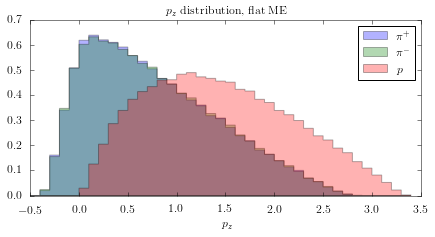

In [203]:
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$')

plt.title(r'$p_z$ distribution, flat ME')

plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')

In [204]:
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

In [205]:
[min(s_ppi1), max(s_ppi1)], [min(s_ppi2), max(s_ppi2)], [min(s_pipi), max(s_pipi)]

([1.0779703556383815, 2.4116042222747724],
 [1.0780355200259606, 2.4117050200446482],
 [0.27914411579687021, 1.6131942500812153])

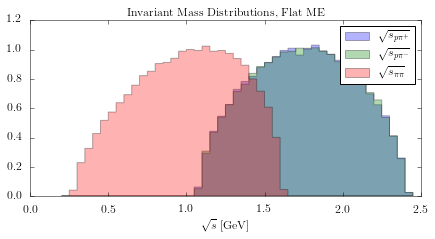

In [206]:
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.title(r'Invariant Mass Distributions, Flat ME')
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.legend()

# ME_Delta ( Delta Resonance)

In [165]:
def get_kin_list_delta(Nevt):
    mp = 0.93827
    mpi = 0.139570
    Egamma = 3.
    
    # Lab-frame gamma+proton momentum
    pGamma = np.array([Egamma, 0., 0., Egamma])
    ppstar = pGamma + np.array([mp,0.,0.,0.])
    Mpstar = np.sqrt(kin.lor_prod(ppstar,ppstar))
    
    def mat_el(M, m1, m2, m3, p1, p2, p3):
        # M = gamma+proton mass, m1 = proton, m2, m3 = pion masses
        # p1 = proton, p2 = pi+, p3 = pi-
        M_Delta=1.232
        G_Delta=0.117
        slope_Delta = 0.06
        
        #sPiplusProton is the invariant mass of the pi+ and proton.
        #cosThetaCM_Delta is the CM-frame polar angle of the Delta (the pi+proton pair)
        
        pDelta = p1+p2
        sPiplusProton = kin.lor_prod(pDelta,pDelta)
        
        sGammaProton = Mpstar**2
        # Magnitude of Gamma 3-momentum in the CM frame
        pGammaCM = (sGammaProton - mp**2)/(2.*np.sqrt(sGammaProton))
        # Magnitude of Delta 3-momentum in the CM frame; Delta recoils against pi-
        # Note that Delta is not necessarily on-shell!
        M_DeltaStar = np.sqrt(sPiplusProton)
        pDeltaCM = np.sqrt( (sGammaProton - M_DeltaStar**2 - mpi**2)**2 - 4.*M_DeltaStar**2 * mpi**2 )/(2.*np.sqrt(sGammaProton))
        EDeltaCM = np.sqrt( M_DeltaStar**2 + pDeltaCM**2 )
        
        
        cosThetaCM_Delta = (EDeltaCM - kin.lor_prod(pDelta,pGamma)/pGammaCM)/pDeltaCM
        if not (np.fabs(cosThetaCM_Delta) <= 1.):
            print cosThetaCM_Delta
        assert np.fabs(cosThetaCM_Delta) <= 1.
        

        norm_Delta =  M_Delta * G_Delta/np.pi / slope_Delta

        BW_den_Delta = (sPiplusProton-M_Delta*M_Delta)**2 + M_Delta*M_Delta*G_Delta*G_Delta

        ME_Delta = norm_Delta * np.exp(-(1.-cosThetaCM_Delta)/slope_Delta) / BW_den_Delta
        #ME_Delta = norm_Delta / BW_den_Delta

        return ME_Delta
    
    
    print "Mpstar = ", Mpstar
    
    pi1_four_vectors = []
    pi2_four_vectors = []
    p_four_vectors = []
    
    weight_list = []

    for i in np.arange(Nevt):           
        pp, ppi1, ppi2 = mc.gen_three_body_decay_products(ppstar, Mpstar, mp, mpi, mpi)

        weight_list.append(mc.get_three_body_weight(Mpstar, mp, mpi, mpi, pp, ppi1, ppi2, mat_el))

        pi1_four_vectors.append(ppi1)
        pi2_four_vectors.append(ppi2)
        p_four_vectors.append(pp)
        #pi_four_vectors.append(ppi2)
            
    return np.array(p_four_vectors), np.array(pi1_four_vectors), np.array(pi2_four_vectors), np.array(weight_list)

In [185]:
p_four_vectors, pi1_four_vectors, pi2_four_vectors, weight_list = get_kin_list_delta(100000)

Mpstar =  2.55146440165


In [186]:
pi1_pzs = pi1_four_vectors[:,3]
pi2_pzs = pi2_four_vectors[:,3]
p_pzs = p_four_vectors[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.366848016323 2.8105159412


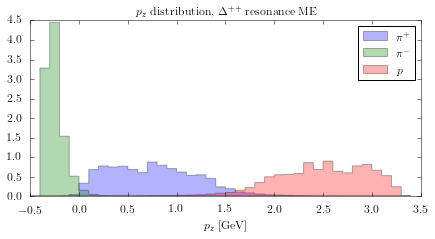

In [187]:
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$ [GeV]')
plt.title(r'$p_z$ distribution, $\Delta^{++}$ resonance ME')

plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')

In [189]:
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

In [190]:
[min(s_ppi1), max(s_ppi1)], [min(s_ppi2), max(s_ppi2)], [min(s_pipi), max(s_pipi)]

([1.0783986608602019, 2.4114735851527875],
 [1.0779658096573794, 2.4118029157175411],
 [0.27924487928441788, 1.6131867088760061])

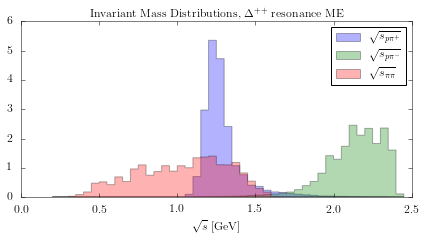

In [192]:
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.title(r'Invariant Mass Distributions, $\Delta^{++}$ resonance ME')
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.legend()

# ME_Rho ( Rho Resonance)

In [172]:
def get_kin_list_rho(Nevt):
    mp = 0.93827
    mpi = 0.139570
    Egamma = 3.
    
    # Lab-frame gamma+proton momentum
    pGamma = np.array([Egamma, 0., 0., Egamma])
    ppstar = pGamma + np.array([mp,0.,0.,0.])
    Mpstar = np.sqrt(kin.lor_prod(ppstar,ppstar))
    
    def mat_el(M, m1, m2, m3, p1, p2, p3):
        # M = gamma+proton mass, m1 = proton, m2, m3 = pion masses
        # p1 = proton, p2 = pi+, p3 = pi-
        M_rho=0.775
        G_rho=0.149
        slope_rho = 0.06

        #s_pipi is the invariant mass of the pi+ and pi-.
        #cosThetaCM_rho is the CM-frame polar angle of the rho (the pi+pi- system)
        pRho = p2+p3
        s_pipi = kin.lor_prod(pRho,pRho)
              
        sGammaProton = Mpstar**2
        # Magnitude of Gamma 3-momentum in the CM frame
        pGammaCM = (sGammaProton - mp**2)/(2.*np.sqrt(sGammaProton))
        # Magnitude of Rho 3-momentum in the CM frame, rho recoils against p
        # Note that rho isn't necessarily on-shell!
        M_rhoStar = np.sqrt(s_pipi)
        pRhoCM = np.sqrt( (sGammaProton - M_rhoStar**2 - mp**2)**2 - 4.*M_rhoStar**2 * mp**2 )/(2.*np.sqrt(sGammaProton))
        ERhoCM = np.sqrt( M_rhoStar**2 + pRhoCM**2 )
        
        cosThetaCM_rho = (ERhoCM - kin.lor_prod(pRho,pGamma)/pGammaCM)/pRhoCM
        if not (np.fabs(cosThetaCM_rho) <= 1.):
            print cosThetaCM_rho
        assert np.fabs(cosThetaCM_rho) <= 1.

        norm_rho =  M_rho * G_rho/np.pi / slope_rho

        BW_den_rho = (s_pipi-M_rho*M_rho)**2 + M_rho * M_rho * G_rho * G_rho

        ME_rho = norm_rho * np.exp(-(1-cosThetaCM_rho)/slope_rho) / BW_den_rho
        #ME_rho = norm_rho / BW_den_rho

        return ME_rho
    
    
    print "Mpstar = ", Mpstar
    
    pi1_four_vectors = []
    pi2_four_vectors = []
    p_four_vectors = []
    
    weight_list = []

    for i in np.arange(Nevt):           
        pp, ppi1, ppi2 = mc.gen_three_body_decay_products(ppstar, Mpstar, mp, mpi, mpi)

        weight_list.append(mc.get_three_body_weight(Mpstar, mp, mpi, mpi, pp, ppi1, ppi2, mat_el))

        pi1_four_vectors.append(ppi1)
        pi2_four_vectors.append(ppi2)
        p_four_vectors.append(pp)
        #pi_four_vectors.append(ppi2)
            
    return np.array(p_four_vectors), np.array(pi1_four_vectors), np.array(pi2_four_vectors), np.array(weight_list)

In [194]:
p_four_vectors, pi1_four_vectors, pi2_four_vectors, weight_list = get_kin_list_rho(100000)

Mpstar =  2.55146440165


In [195]:
pi1_pzs = pi1_four_vectors[:,3]
pi2_pzs = pi2_four_vectors[:,3]
p_pzs = p_four_vectors[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.363876829592 2.82332351251


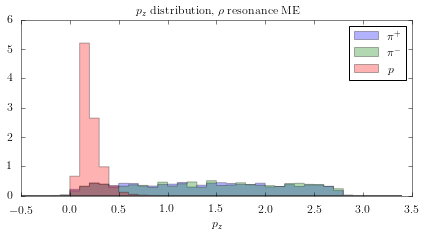

In [196]:
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$')
plt.title(r'$p_z$ distribution, $\rho$ resonance ME')
plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')

In [197]:
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

In [198]:
[min(s_ppi1), max(s_ppi1)], [min(s_ppi2), max(s_ppi2)], [min(s_pipi), max(s_pipi)]

([1.0783972128059016, 2.4113661366211812],
 [1.0781625148066072, 2.411489839554767],
 [0.27918631674034949, 1.6131898819188297])

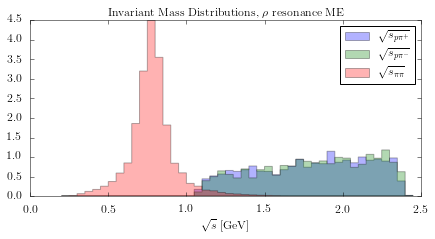

In [199]:
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.title(r'Invariant Mass Distributions, $\rho$ resonance ME')
plt.legend()